In [1]:
import random, math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import numpy as np
import copy

from matplotlib import style
style.use('seaborn')

In [2]:
random.seed(4)

In [5]:
def exprand(lambdr):
    return np.random.exponential(1/lambdr)

In [6]:
a = []
b = []
for i in range(100000):
    a.append(np.random.exponential(5))
    b.append(exprand(1/5))
print(statistics.mean(a))
print(statistics.mean(b))

5.006739793174748
5.008199914781664


In [7]:
class Customer:
    def __init__(self, customer_id, check_in_time, time_to_process_this_customer):
        self.customer_id = customer_id  # номер человека
        self.check_in_time = check_in_time #время, в которое он придет
        self.time_to_process_this_customer = time_to_process_this_customer # время на обработку этого человека (+1 временное решение того, что 0 требуется на процесс)
        self.spent_time=time_to_process_this_customer
        
    def __repr__(self):
        return f'id={self.customer_id}, check_in= {self.check_in_time}, time_to_process_this_customer= {self.time_to_process_this_customer}'

# Обработчик
class Handler:
    def __init__(self, id):
        self.id = id
        self.powerness = 1.0
        self.tmp_powerness = self.powerness
        self.customer = None

    def process_customer(self, customer):
        self.customer.time_to_process_this_customer -= self.tmp_powerness
        if self.customer.time_to_process_this_customer <= 0:
            self.tmp_powerness = -self.customer.time_to_process_this_customer
    
    def process_own_customer(self, mean_time_spent):
        if self.customer:
            self.process_customer(self.customer)
            if self.customer.time_to_process_this_customer <= 0:
                mean_time_spent.append(self.customer.spent_time)
                self.customer = None
                
    def process_customers(self, list_of_customers, mean_time_spent):  
        self.process_own_customer(mean_time_spent)
        while not self.customer and self.tmp_powerness > 0 and list_of_customers:
            self.customer = list_of_customers.pop(0)
            self.process_own_customer(mean_time_spent)
            if self.customer:
                break
        self.tmp_powerness = self.powerness
                    
    def get_tmp_powerness(self):
        return self.tmp_powerness
    
    def get_powerness(self):
        return self.powerness

In [8]:
# Вeликий обрабатор!
class MainHandler:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        #self.number_of_customers = number_of_customers
        self.list_of_customers = []
        self.list_of_tmp_customers = []
        self.list_of_handlers = []
        self.number_of_customers_left  = 0
        self.number_of_customers_handle  = 0
        self.customers_growth = []
        self.customers_all = 0
        self.mean_time_spent = []
        self.handler_load = []
        self.lambda_ = lambda_
        self.nu = nu
        
    def get_next(self, customer_id, check_in, nu):
        # Устанавливаем номер человека
        # время, через котрое он придет
        # и время, которое требуется на его обработку
        customer = Customer(customer_id, check_in, abs(exprand(nu)))
    
        return customer
    
    def generate_customers(self, steps):
        lost_time = steps  # оставшееся количество шагов == время для генерации

        customer_id = 0
        
        for i in range(steps):
            tmp = round(exprand(self.lambda_))
            '''print(tmp)'''
            if tmp == 0:
                tmp = 1
            
            for j in range(tmp):
                customer = self.get_next(customer_id, i, self.nu)
                '''print(customer)'''
                customer_id += 1
                self.list_of_customers.append(customer)

        #print("Number of customers:" + str(len(self.list_of_customers)))
        #for customer in self.list_of_customers:
            #print("check_in_time: "+str(customer.check_in_time) + " and time_to_process_this_customer:" + str(customer.time_to_process_this_customer))

    def start(self, steps):
        self.generate_customers(steps)
        
        for i in range(self.number_of_handlers):
            self.list_of_handlers.append(Handler(i))

        for i in range(steps):
            new_customers = [customer for customer in self.list_of_customers if customer.check_in_time == i]
            
            # save customers number
            self.customers_all += len(new_customers)
            self.customers_growth.append(self.customers_all)
            self.number_of_customers_handle+=len(new_customers)
            
            # обрабатываем людей
            for handler in self.list_of_handlers:
                handler.process_customers(new_customers, self.mean_time_spent)
        
            number_of_working_handlers = 0
            for handler in self.list_of_handlers:
                if handler.customer:
                    number_of_working_handlers += 1
            
            self.handler_load.append(number_of_working_handlers)
            
            self.number_of_customers_left+=len(new_customers)
            
            self.number_of_customers_handle-=len(new_customers)
                
            # продолжаем

    def clear(self):
        self.list_of_customers.clear()
        self.list_of_handlers.clear()
        self.number_of_customers_left  = 0
        self.customers_growth.clear()
        self.customers_all = 0
        self.mean_time_spent.clear()
        self.handler_load.clear()
        
    # statistics
    def get_customers(self):
        return self.list_of_customers
    
    # количество пришедших кастомеров с начала
    def get_customer_growth(self):
        return self.customers_growth
    
    # Среднее количество НОВЫХ заявок в системе
    def get_mean_customer_growth(self):
        return self.customers_all/len(self.customers_growth)
    
    # количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_handler_load(self):
        return self.handler_load
    
    # Среднее количество ОБРАБАТЫВАЕМЫХ заявок в системе
    def get_mean_handler_load(self):
        sum_load = 0
        for load in self.handler_load:
            sum_load += load
        
        return sum_load/len(self.handler_load)
    
    # среднее время пребыания?
    def get_mean_time_spent(self):
        return statistics.mean(self.mean_time_spent)
    
    # вероятность отказа
    def get_deny_probability(self):
        return self.number_of_customers_left/self.customers_all

In [9]:
class Model:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.__handler = MainHandler(number_of_handlers, 1/lambda_, nu)
        self.__time = None
        
    def run(self):
        if self.__time is None or self.__handler is None:
            raise ValueError
        
        self.__handler.start(self.__time)
        
    def set_time(self, time):
        if time <= 0:
            raise ValueError
            
        self.__time = time
        
    def get_time(self):
        return self.__time
    
    def get_handler(self):
        return self.__handler
    
    def set_handler(self, handler):
        self.__handler = handler
    
    handler = property(get_handler, set_handler)
    time = property(get_time, set_time)


In [10]:
import matplotlib
from matplotlib.pyplot import figure

In [11]:
class Theory:
    def __init__(self, number_of_handlers, lambda_, nu):
        self.number_of_handlers = number_of_handlers
        self.lambda_ = lambda_
        self.nu = nu

    # вероятность, что k обработчиков заняты
    def get_k_handlers_load_probability(self, k):
        summa = 0
        if k == 0:
            return 1 - sum([self.get_k_handlers_load_probability(a) for a in range(1, self.number_of_handlers+1)])
        for i in range(0, self.number_of_handlers + 1):
            summa += pow(self.lambda_, i) / (math.factorial(i) * pow(self.nu, i))
        
        return pow(self.lambda_, k) / (math.factorial(k) * pow(self.nu, k) * summa)

    # вероятность отказа
    def get_loss_probability(self):
        return self.get_k_handlers_load_probability(self.number_of_handlers)

    # относительная пропускная способность - вероятность, что заявка будет обслужена
    def get_handle_probability(self):
        return 1 - self.get_loss_probability()

    # среднее время поступления заявки
    def get_mean_waiting_time(self):
        return self.lambda_

    # среднее время обслуживания
    def get_mean_time_spent(self):
        return 1 / self.nu

    # абсолютная пропускная способность - среднее число заявок, обслуживаемых в единицу времени
    def absolute_bandwidth(self):
        return self.lambda_ * self.get_handle_probability()

    # число покупалетей за все время
    def get_customers_all(self, steps):
        return self.lambda_ * steps

    # среднее число занятых касс - интенсивность потока обслуженных системой заявок (в единицу времени)
    def get_mean_handler_load(self):
        a = 0
        for n in range(0, self.number_of_handlers):
            a += n * self.get_k_handlers_load_probability(n)
        return a

    def get_number_of_customers_left(self, steps):
        return self.get_customers_all(steps) * self.get_loss_probability()
    
    def get_number_of_customers_handle(self, steps):
        return self.get_customers_all(steps) * self.get_handle_probability()

In [12]:
def describe_model(model_, theory=None, print_info=False):
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    ax_cust, ax_load, ax_time_proc, ax_time_proc_g = *axs[0], *axs[1]

    customers = model_.handler.get_customer_growth()
    ax_cust.plot(customers)
    ax_cust.set(xlabel='Time', ylabel='Number of customers', title='Customer growth')
    ax_cust.grid()

    load = model_.handler.get_handler_load()
    ax_load.plot(load)
    ax_load.set(xlabel='Time', ylabel='Handlers working', title='Number of handlers working on each step')
    ax_load.grid()

    x = model_.handler.mean_time_spent
    n, bins, patches = ax_time_proc.hist(x)
    ax_time_proc.set(xlabel='Time to process customer', ylabel='Customers',
                     title= 'Histogram with mean time to process customers')
    ax_time_proc.grid(True)

    load = model_.handler.mean_time_spent
    ax_time_proc_g.plot(load)
    ax_time_proc_g.set(xlabel='Time', ylabel='Time spent', title='Time spent by customers')
    ax_time_proc_g.grid()

    plt.savefig(f'graph_{id(model_)}.png')
    plt.show()
    get_proc_str = lambda x, y: '{}%'.format(str((x-y)/y*100)[:4])
    if theory and print_info:
        print('КЛИЕНТЫ\n')
        print('Всего клиентов')
        print('\tМодель:', model_.handler.customers_all)
        print('\tТеория:', theory.get_customers_all(model_.time))
        print('\tОтклонение:', get_proc_str(model_.handler.customers_all, theory.get_customers_all(model_.time)))
        print('Всего обработано клиентов')
        print('\tМодель:', model_.handler.number_of_customers_handle)
        print('\tТеория:', theory.get_number_of_customers_handle(model_.time))
        print('\tОтклонение:', get_proc_str(model_.handler.number_of_customers_handle,
                                            theory.get_number_of_customers_handle(model_.time)))        
        print('Клиентов потеряно')
        print('\tМодель:', model_.handler.number_of_customers_left)
        print('\tТеория:', theory.get_number_of_customers_left(model_.time))
        print('\tОтклонение:',get_proc_str(model_.handler.number_of_customers_left,
                                           theory.get_number_of_customers_left(model_.time)))
        print('Средний прирост клиентов в единицу времени')
        print('\tМодель:', model_.handler.get_mean_customer_growth())
        print('\tТеория:', theory.get_mean_waiting_time())
        print('\tОтклонение:',get_proc_str(model_.handler.get_mean_customer_growth(),
                                           theory.get_mean_waiting_time()))
        print('\nОБСЛУЖИВАНИЕ\n')
        print('Среднее время обслуживания')
        print('\tМодель:', model_.handler.get_mean_time_spent())
        print('\tТеория:', theory.get_mean_time_spent())
        print('\tОтклонение:',get_proc_str(model_.handler.get_mean_time_spent(),
                                           theory.get_mean_time_spent()))
        print('Вероятность отказа в обслуживании')
        print('\tМодель:', model_.handler.get_deny_probability())
        print('\tТеория:', theory.get_loss_probability())
        print('\tОтклонение:',get_proc_str(model_.handler.get_deny_probability(),
                                           theory.get_loss_probability()))
        print('Среднее количество занятых обработчиков')
        print('\tМодель:', model_.handler.get_mean_handler_load())
        print('\tТеория:', theory.get_mean_handler_load())
        print('\tОтклонение:',get_proc_str(model_.handler.get_mean_handler_load(),
                                           theory.get_mean_handler_load()))

In [13]:
steps=1000
params = (  # количество обработчиков, лямбда, мю
    (7, 13, 3),
    (10, 4, 8),
    (5, 15, 4)
)

In [14]:
m_t = []
for p_set in params:
    model = Model(*p_set)
    theory = Theory(*p_set)
    model.time = steps
    model.run()
    m_t.append((model, theory))

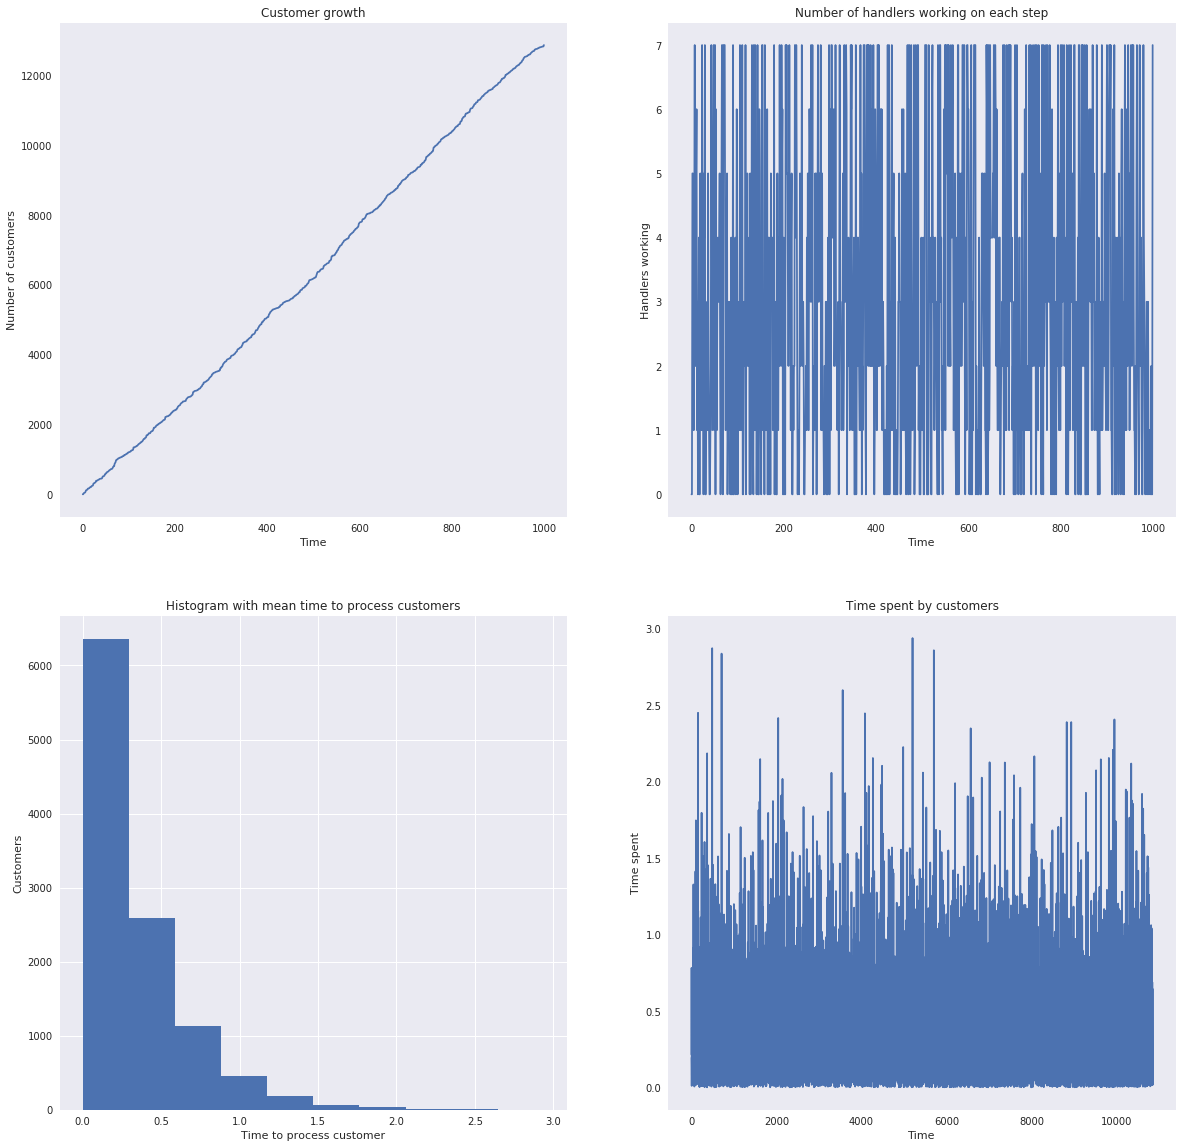

КЛИЕНТЫ

Всего клиентов
	Модель: 12867
	Теория: 13000
	Отклонение: -1.0%
Всего обработано клиентов
	Модель: 10856
	Теория: 11951.719066509693
	Отклонение: -9.1%
Клиентов потеряно
	Модель: 2011
	Теория: 1048.280933490307
	Отклонение: 91.8%
Средний прирост клиентов в единицу времени
	Модель: 12.867
	Теория: 13
	Отклонение: -1.0%

ОБСЛУЖИВАНИЕ

Среднее время обслуживания
	Модель: 0.3342931753175712
	Теория: 0.3333333333333333
	Отклонение: 0.28%
Вероятность отказа в обслуживании
	Модель: 0.15629128779047174
	Теория: 0.08063699488386977
	Отклонение: 93.8%
Среднее количество занятых обработчиков
	Модель: 3.019
	Теория: 3.4194473913161425
	Отклонение: -11.%


In [15]:
describe_model(*m_t[0], print_info=True)

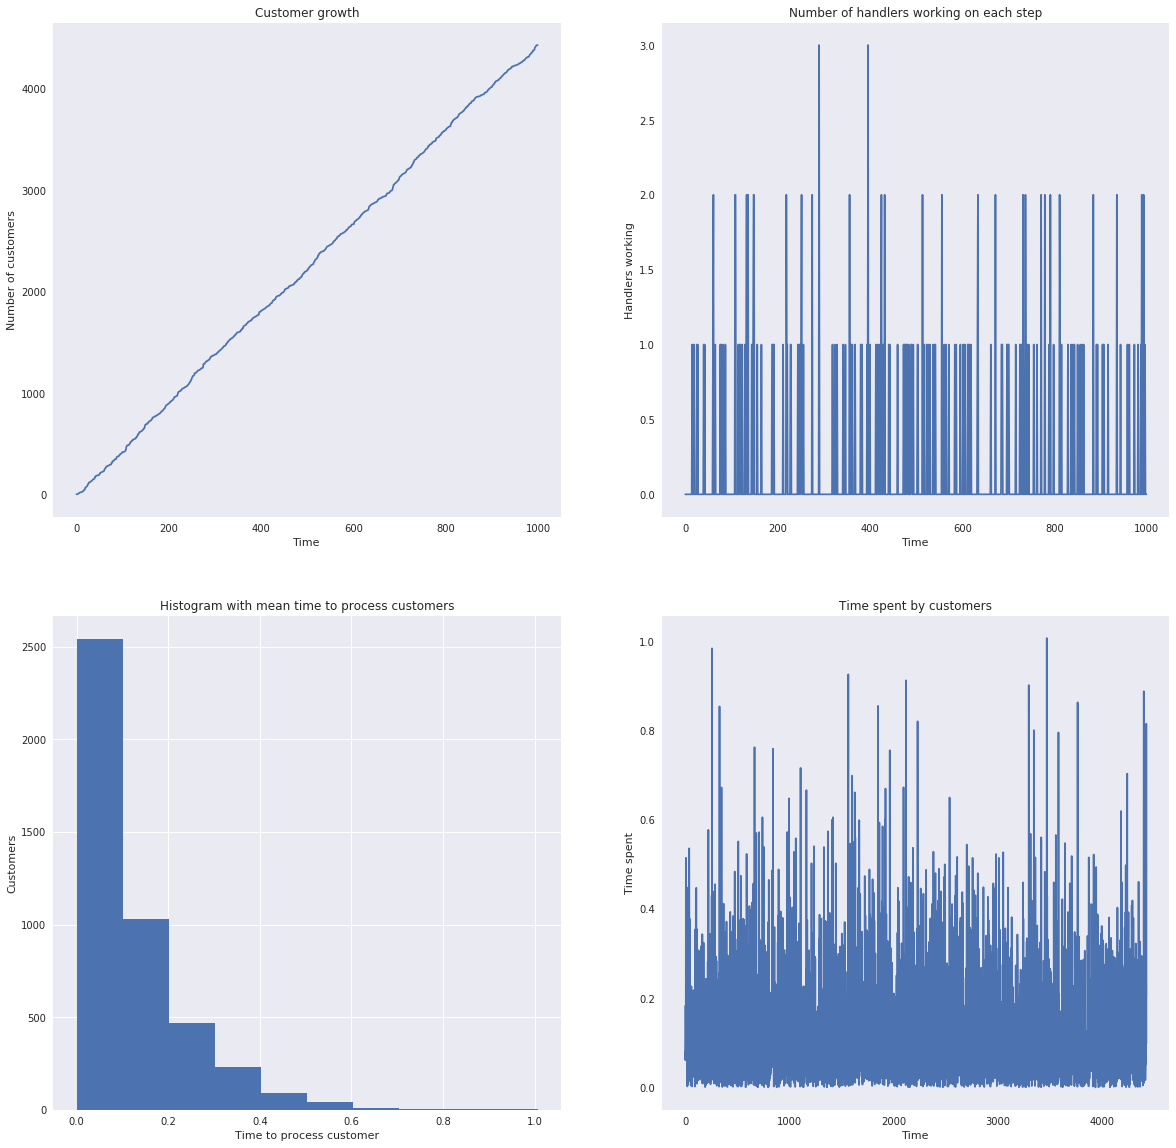

КЛИЕНТЫ

Всего клиентов
	Модель: 4427
	Теория: 4000
	Отклонение: 10.6%
Всего обработано клиентов
	Модель: 4427
	Теория: 3999.999999347095
	Отклонение: 10.6%
Клиентов потеряно
	Модель: 0
	Теория: 6.529046487877025e-07
	Отклонение: -100%
Средний прирост клиентов в единицу времени
	Модель: 4.427
	Теория: 4
	Отклонение: 10.6%

ОБСЛУЖИВАНИЕ

Среднее время обслуживания
	Модель: 0.12230163294008417
	Теория: 0.125
	Отклонение: -2.1%
Вероятность отказа в обслуживании
	Модель: 0.0
	Теория: 1.6322616219692563e-10
	Отклонение: -100%
Среднее количество занятых обработчиков
	Модель: 0.198
	Теория: 0.4999999982861254
	Отклонение: -60.%


In [16]:
describe_model(*m_t[1], print_info=True)

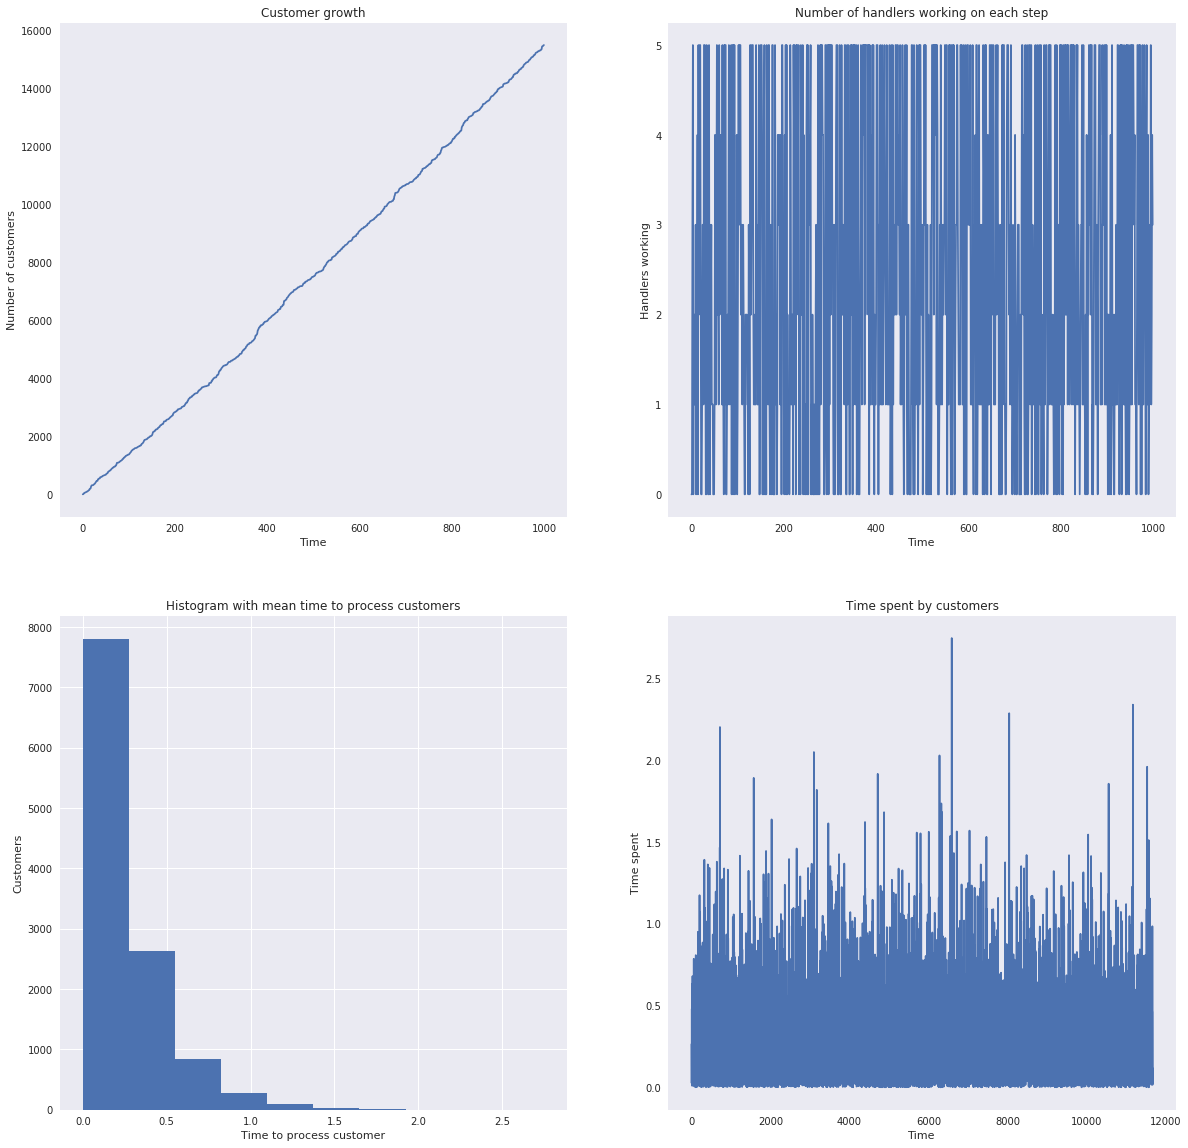

КЛИЕНТЫ

Всего клиентов
	Модель: 15485
	Теория: 15000
	Отклонение: 3.23%
Всего обработано клиентов
	Модель: 11681
	Теория: 12350.743274594695
	Отклонение: -5.4%
Клиентов потеряно
	Модель: 3804
	Теория: 2649.2567254053038
	Отклонение: 43.5%
Средний прирост клиентов в единицу времени
	Модель: 15.485
	Теория: 15
	Отклонение: 3.23%

ОБСЛУЖИВАНИЕ

Среднее время обслуживания
	Модель: 0.24948143839517284
	Теория: 0.25
	Отклонение: -0.2%
Вероятность отказа в обслуживании
	Модель: 0.24565708750403617
	Теория: 0.17661711502702024
	Отклонение: 39.0%
Среднее количество занятых обработчиков
	Модель: 2.453
	Теория: 2.204600243513573
	Отклонение: 11.2%


In [17]:
describe_model(*m_t[2], print_info=True)